In [ ]:

import kagglehub

# Download the deepfake dataset from Kaggle
path = kagglehub.dataset_download("aryansingh16/deepfake-dataset")
print("Path to dataset files:", path)





In [1]:
# !unzip -q {path} -d /content/real_vs_fake

# Checking the Downloaded Dataset Files

# Ensures that the dataset downloaded correctly.


In [2]:
import os

dataset_path = "/kaggle/input/deepfake-dataset"
print("Contents of the dataset directory:")
print(os.listdir(dataset_path))


Contents of the dataset directory:
['real_vs_fake']


In [3]:
import os

dataset_path = "/kaggle/input/deepfake-dataset/real_vs_fake"

# List the contents of the dataset
print("Contents of real_vs_fake:")
print(os.listdir(dataset_path))


Contents of real_vs_fake:
['real-vs-fake']


In [4]:
import os

# Define the path to the 'real-vs-fake' directory
real_vs_fake_path = os.path.join(dataset_path, 'real-vs-fake')

# List the contents of the 'real-vs-fake' directory
print("Contents of 'real-vs-fake':")
print(os.listdir(real_vs_fake_path))


Contents of 'real-vs-fake':
['valid', 'test', 'train']


In [5]:
import os

# Define the path to the 'real-vs-fake' directory
real_vs_fake_path = "/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake"

# This loops through the three dataset folders: train, valid, and test.
for split in ['train', 'valid', 'test']:
    #dynamically creates the path to each folder.
    split_path = os.path.join(real_vs_fake_path, split)
    print(f"Contents of '{split}' directory:")
    print(os.listdir(split_path))
    print()


Contents of 'train' directory:
['fake', 'real']

Contents of 'valid' directory:
['fake', 'real']

Contents of 'test' directory:
['fake', 'real']



In [6]:
import os
# For numerical operations
import numpy as np
#deep learning framework ,  for building and training neural networks.
import tensorflow as tf
from tensorflow import keras

# Define dataset path, stores the dataset's location
DATASET_PATH = "/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake"

print("Libraries imported and dataset path set.")


Libraries imported and dataset path set.


In [7]:
# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 # loading and processing 32 image at one time for processing, to optimize the memory

# Data Augmentation for training images (  prevent overfitting by generating more diverse training samples.)
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation & Test ( only rescaling)
valid_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

print(" Data augmentation and rescaling defined.")


 Data augmentation and rescaling defined.


In [8]:
# Loading and Preparing Dataset for Deepfake Detection

# Define dataset paths
train_dir = os.path.join(dataset_path, "real-vs-fake", "train")
valid_dir = os.path.join(dataset_path, "real-vs-fake", "valid")
test_dir = os.path.join(dataset_path, "real-vs-fake", "test")

# Create training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Create validation generator
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Create test generator
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Data generators are ready.")


Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Data generators are ready.


# **Build the Model Using EfficientNetB3 Backbone**

Now, let's define the CNN model using EfficientNetB3 as the backbone for feature extraction, with a dropout layer for regularization and a final fully connected layer for binary classification


In [9]:
# Build the model with EfficientNetB3 backbone
base_model = keras.applications.EfficientNetB3(
    include_top=False,
    weights='imagenet',  # Use ImageNet weights for transfer learning
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the base model initially to avoid training the weights during the first phase training
base_model.trainable = False

# Build the top layers for the model
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

# Create the complete model
model = keras.Model(inputs, outputs)

# Compile the model with Adam optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model built and compiled.")


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built and compiled.


# **Define Callbacks for Model Training**

Now, let's define the callbacks that will be used during training to save the best model, reduce the learning rate, and stop early if needed.


In [10]:
# Define the path to save the best model
checkpoint_path = "best_model.keras"

# ModelCheckpoint: Save the best model based on validation accuracy
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate if validation loss stops improving
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# EarlyStopping: Stop training if validation loss stops improving
early_stop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# CSVLogger: Log training history to a CSV file
csv_logger = keras.callbacks.CSVLogger("training_log.csv", append=True)

print("Callbacks defined.")


Callbacks defined.


In [11]:
print("Using device:", tf.test.gpu_device_name())


Using device: /device:GPU:0


# **Train the Model**

Now, let's train the model using the defined callbacks, data generators, and model.


In [12]:
# Train the model
epochs = 4

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stop_cb, csv_logger]
)

print(" Training complete!")


Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3189/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.4994 - loss: 0.7006
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.keras
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 2496s 770ms/step - accuracy: 0.4994 - loss: 0.7006 - val_accuracy: 0.5000 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 2/4
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.5020 - loss: 0.6983
Epoch 2: val_accuracy improved from 0.50000 to 0.50010, saving model to best_model.keras
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 1390s 435ms/step - accuracy: 0.5020 - loss: 0.6983 - val_accuracy: 0.5001 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/4
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4983 - loss: 0.6975
Epoch 3: val_accuracy improved from 0.50010 to 0.52150, saving model to best_model.keras
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 1426s 446ms/step - accuracy: 0.4983 - loss: 0.6975 - val_accuracy: 0.5215 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 4/4
3189/3189 ━━━

# Unfreeze Base Model for Fine-Tuning


In [13]:
# Unfreeze the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Reduced LR
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Base model unfrozen and recompiled.")

Base model unfrozen and recompiled.


# Adjust Data Augmentation

Add more aggressive augmentation to handle subtle deepfake artifacts


In [14]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],  #  brightness
    fill_mode='nearest'
)

# Class Balance Check

Add class weights if there’s an imbalance:


In [15]:
# Calculate class weights (example: if fake = 60%, real = 40%)
import numpy as np

class_counts = np.array([len(os.listdir(os.path.join(train_dir, 'real'))),
                         len(os.listdir(os.path.join(train_dir, 'fake')))])
total = class_counts.sum()
class_weights = {0: total/class_counts[0], 1: total/class_counts[1]}
print("Class weights:", class_weights)

Class weights: {0: 1.997631213171238, 1: 2.002374411302983}


# Train with Fine-Tuning


In [ ]:
# Continue training with unfrozen layers
fine_tune_epochs = 4
total_epochs =2+fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start from last epoch
    validation_data=valid_generator,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stop_cb, csv_logger],
    class_weight=class_weights  
)

Epoch 4/6
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7246 - loss: 1.0390
Epoch 4: val_accuracy improved from 0.52150 to 0.91485, saving model to best_model.keras
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 1563s 455ms/step - accuracy: 0.7246 - loss: 1.0389 - val_accuracy: 0.9148 - val_loss: 0.2145 - learning_rate: 1.0000e-05
Epoch 5/6
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9194 - loss: 0.4071
Epoch 5: val_accuracy improved from 0.91485 to 0.95365, saving model to best_model.keras
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 1418s 444ms/step - accuracy: 0.9194 - loss: 0.4071 - val_accuracy: 0.9536 - val_loss: 0.1242 - learning_rate: 1.0000e-05
Epoch 6/6
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9501 - loss: 0.2681
Epoch 6: val_accuracy improved from 0.95365 to 0.96880, saving model to best_model.keras
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 1555s 487ms/step - accuracy: 0.9501 - loss: 0.2681 - val_accuracy: 0.9688 - val_loss: 0.0856 - learning_rate: 1.0000e-05
Restoring 

In [17]:
model.save('my_deepfake_model_with_fine_tuning_04_April.keras')

In [18]:
from IPython.display import FileLink
FileLink(r'my_deepfake_model_with_fine_tuning_04_April.keras')

/kaggle/working/my_deepfake_model_with_fine_tuning_04_April.keras

In [19]:
#ew imports
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as K

In [20]:
# Custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [ ]:
def compile_model(model):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            F1Score()
        ]
    )


compile_model(model)


Final Evaluation:


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 308ms/step

Classification Report:
              precision    recall  f1-score   support

        Real       0.95      0.99      0.97     10000
        Fake       0.99      0.94      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

Confusion Matrix:
[[9939   61]
 [ 575 9425]]


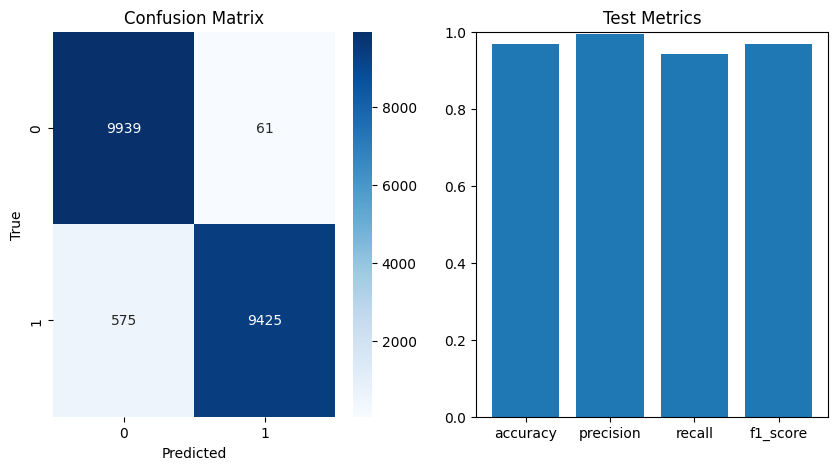

In [22]:
def evaluate_model(model, test_generator):
    # Generate predictions
    y_pred = model.predict(test_generator)
    y_pred = (y_pred > 0.5).astype(int)

    # Get true labels
    y_true = test_generator.classes

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Visual metrics
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    values = [model.evaluate(test_generator, verbose=0)[i+1] for i in range(4)]
    plt.bar(metrics, values)
    plt.title('Test Metrics')
    plt.ylim(0, 1)
    plt.show()

#after training
print("\nFinal Evaluation:")
evaluate_model(model, test_generator)

In [23]:
"""def make_gradcam_heatmap(img_array, model, last_conv_layer_name='top_conv'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # For binary classification

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap[0]

def visualize_explanations(test_generator, model, num_samples=3):
    images, labels = next(test_generator)

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_array = np.expand_dims(images[i], axis=0)
        heatmap = make_gradcam_heatmap(img_array, model)

        # Resize and create overlay
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.4 + images[i] * 0.6

        plt.subplot(1, num_samples, i+1)
        plt.imshow(superimposed_img.astype('uint8'))
        plt.title(f"True: {'Real' if labels[i]==0 else 'Fake'}\nPred: {model.predict(img_array)[0][0]:.2f}")
        plt.axis('off')
    plt.show()

# Run after evaluation
print("\nSample Explanations:")
visualize_explanations(test_generator, model)
"""

'def make_gradcam_heatmap(img_array, model, last_conv_layer_name=\'top_conv\'):\n    grad_model = tf.keras.models.Model(\n        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]\n    )\n\n    with tf.GradientTape() as tape:\n        conv_outputs, predictions = grad_model(img_array)\n        loss = predictions[:, 0]  # For binary classification\n\n    grads = tape.gradient(loss, conv_outputs)\n    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))\n\n    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)\n    heatmap = np.maximum(heatmap, 0)\n    heatmap /= np.max(heatmap)\n    return heatmap[0]\n\ndef visualize_explanations(test_generator, model, num_samples=3):\n    images, labels = next(test_generator)\n\n    plt.figure(figsize=(15, 5))\n    for i in range(num_samples):\n        img_array = np.expand_dims(images[i], axis=0)\n        heatmap = make_gradcam_heatmap(img_array, model)\n\n        # Resize and create overlay\n        h

In [ ]:
# After all training and evaluation
model.save('my_deepfake_model_with_fine_tuning_04_April_part2.keras')  

In [25]:
from IPython.display import FileLink
FileLink(r'my_deepfake_model_with_fine_tuning_04_April_part2.keras')

/kaggle/working/my_deepfake_model_with_fine_tuning_04_April_part2.keras

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Error: Unable to load image at {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, target_size) 
    img = img.astype('float32') / 255.0  
    img = np.expand_dims(img, axis=0)  
    return img


In [27]:
image_path2 = '/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/real/00007.jpg' 
input_image = preprocess_image(image_path2)
prediction = model.predict(input_image)

threshold = 0.6 
if prediction[0][0] < threshold:
    print("Prediction: Fake")
else:
    print("Prediction: Real")

print(f"Confidence Score: {prediction[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Prediction: Real
Confidence Score: 0.9878


In [28]:
image_path3 = '/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg' 
input_image3 = preprocess_image(image_path3)
prediction3 = model.predict(input_image3)

threshold = 0.6 
if prediction3[0][0] < threshold:
    print("Prediction: Fake")
else:
    print("Prediction: Real")

print(f"Confidence Score: {prediction3[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction: Fake
Confidence Score: 0.0589


In [29]:
image_path4 = '/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/fake/00KEKJJ1Q4.jpg' 
input_image4 = preprocess_image(image_path4)
prediction4 = model.predict(input_image4)

threshold = 0.6 
if prediction4[0][0] < threshold:
    print("Prediction: Fake")
else:
    print("Prediction: Real")

print(f"Confidence Score: {prediction4[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction: Fake
Confidence Score: 0.0001


In [30]:
from IPython.display import FileLink
FileLink(r'best_model.keras')

/kaggle/working/best_model.keras

In [31]:
image_path5 = '/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/real/00104.jpg' 
input_image5 = preprocess_image(image_path5)
prediction5 = model.predict(input_image5)

threshold = 0.6 
if prediction5[0][0] < threshold:
    print("Prediction 5: Fake")
else:
    print("Prediction 5: Real")

print(f"Confidence Score of 5th is: {prediction5[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction 5: Real
Confidence Score of 5th is: 0.9823


In [32]:
image_path6 = '/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/real/00170.jpg' 
input_image6 = preprocess_image(image_path6)
prediction6 = model.predict(input_image6)

threshold = 0.6 
if prediction6[0][0] < threshold:
    print("Prediction 6: Fake")
else:
    print("Prediction 6: Real")

print(f"Confidence Score of 6th is: {prediction6[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction 6: Real
Confidence Score of 6th is: 0.9847


In [33]:
image_path7 = '/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/fake/02YD6CVUGS.jpg' 
input_image7 = preprocess_image(image_path7)
prediction7 = model.predict(input_image7)

threshold = 0.6 
if prediction7[0][0] < threshold:
    print("Prediction 7: Fake")
else:
    print("Prediction 7: Real")

print(f"Confidence Score of 7th is: {prediction7[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction 7: Fake
Confidence Score of 7th is: 0.0036


In [35]:
image_path8 = '/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/fake/02XAKN4F4U.jpg' 
input_image8 = preprocess_image(image_path8)
prediction8 = model.predict(input_image8)

threshold = 0.6 
if prediction8[0][0] < threshold:
    print("Prediction 8: Fake")
else:
    print("Prediction 8: Real")

print(f"Confidence Score of 8th is: {prediction8[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction 8: Fake
Confidence Score of 8th is: 0.0000


In [36]:
image_path9 = '/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/fake/02TPLQKRQB.jpg' 
input_image9 = preprocess_image(image_path9)
prediction9 = model.predict(input_image9)

threshold = 0.6 
if prediction9[0][0] < threshold:
    print("Prediction 9: Fake")
else:
    print("Prediction 9: Real")

print(f"Confidence Score of 9th is: {prediction9[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction 9: Fake
Confidence Score of 9th is: 0.0024
